## packages

In [191]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from statsmodels.tsa.seasonal import seasonal_decompose 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn

from config import PROCESSED_DATA_PATH , PLOTS_DIR , FORECASTS_DIR
from src.data_loader import save_fig


## Loading Data

In [192]:
df = pd.read_csv('../data/processed/preprocessed_data.csv',index_col=0,parse_dates=True)

def filepath(name):
    return PLOTS_DIR+f'/{name}.png'

def filepath_f(name):
    return FORECASTS_DIR+f'/{name}.png'

In [193]:
df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Features Engeenring

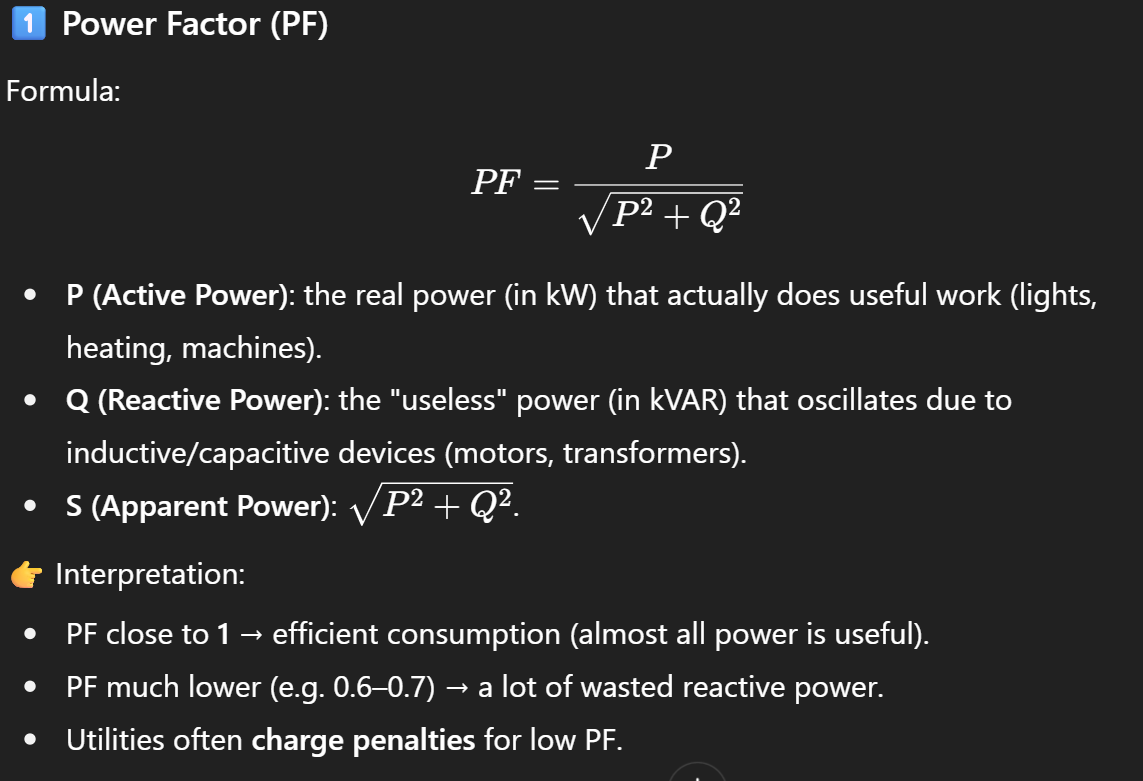

In [194]:
def compute_power_factor(df):
    P = df["global_active_power"]
    Q = df["global_reactive_power"]
    S = np.sqrt(P**2 + Q**2)   # Apparent power
    df["power_factor"] = round(P/S ,5 ) # Avoid division by zero
    return df




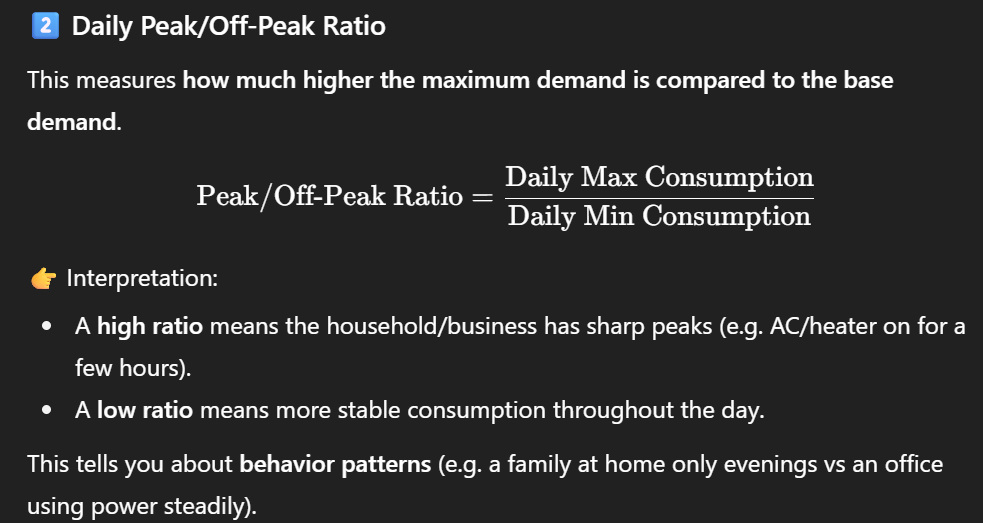

In [195]:
def compute_peak_offpeak_ratio(df):
    daily = df["global_active_power"].resample("D").agg(["max", "min"])
    daily["Peak_OffPeak_Ratio"] = daily["max"] / daily["min"].replace(0, np.nan)  # avoid /0
    return daily["Peak_OffPeak_Ratio"]


In [196]:
df = compute_power_factor(df)
df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,power_factor
dt,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,0.99512
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,0.99671
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,0.99573
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,0.99569
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,0.98979


In [197]:
peak_offpeak = compute_peak_offpeak_ratio(df)
peak_offpeak.head()

dt
2006-12-16    27.133803
2006-12-17    34.291262
2006-12-18    30.485149
2006-12-19    40.412371
2006-12-20    29.643564
Freq: D, Name: Peak_OffPeak_Ratio, dtype: float64

In [198]:
peak_offpeak.describe()

count    1442.000000
mean       28.277546
std        11.713586
min         1.000000
25%        20.775074
50%        26.717757
75%        34.050922
max        96.410256
Name: Peak_OffPeak_Ratio, dtype: float64

<Axes: xlabel='dt'>

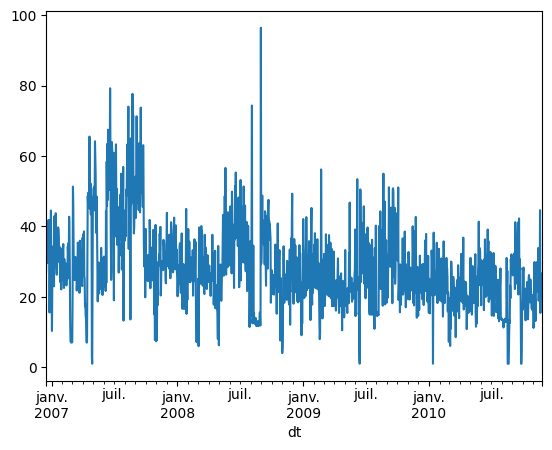

In [199]:
peak_offpeak.plot()

In [200]:

df1 = df.resample('D').mean()

In [201]:
df1['power_factor'].describe()

count    1442.000000
mean        0.964081
std         0.028689
min         0.823260
25%         0.953477
50%         0.974781
75%         0.983063
max         0.998768
Name: power_factor, dtype: float64

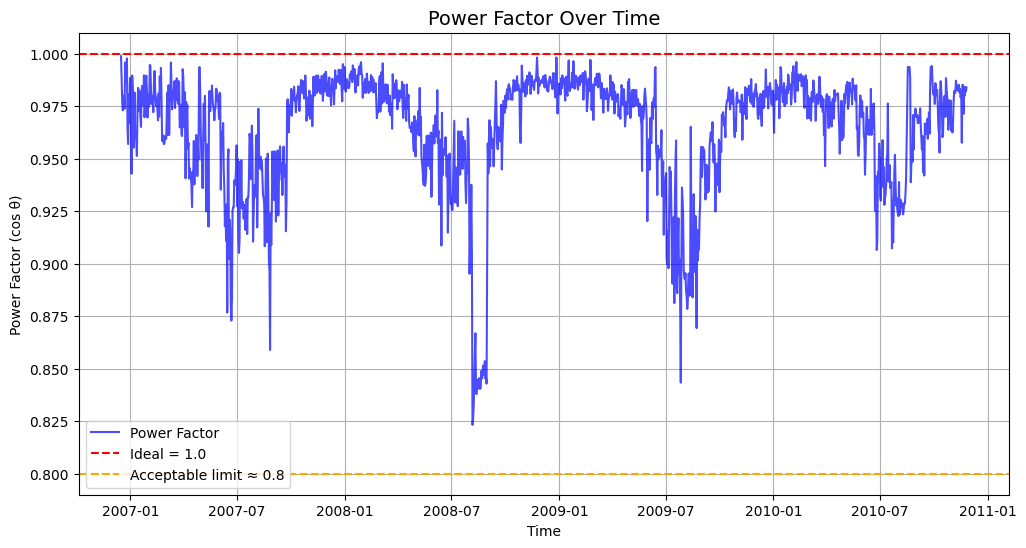

In [202]:

plt.figure(figsize=(12,6))
plt.plot(df1.index, df1["power_factor"], color="blue", alpha=0.7, label="Power Factor")
plt.axhline(1, color="red", linestyle="--", label="Ideal = 1.0")
plt.axhline(0.8, color="orange", linestyle="--", label="Acceptable limit ≈ 0.8")

plt.title("Power Factor Over Time", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Power Factor (cos θ)")
plt.legend()
plt.grid(True)
plt.savefig(filepath(name='Power Factor Over Time'))


## SARIMA/ARIMA

### Stationarity Check :

In [203]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    result = adfuller(series.dropna())
    # print(result)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary")
    else:
        print(" The series is NOT stationary")
        
check_stationarity(df1["power_factor"])
check_stationarity(df1["global_active_power"])


ADF Statistic: -4.07717607862499
p-value: 0.001056165335825885
The series is stationary
ADF Statistic: -3.7082399827219965
p-value: 0.003998733004312964
The series is stationary


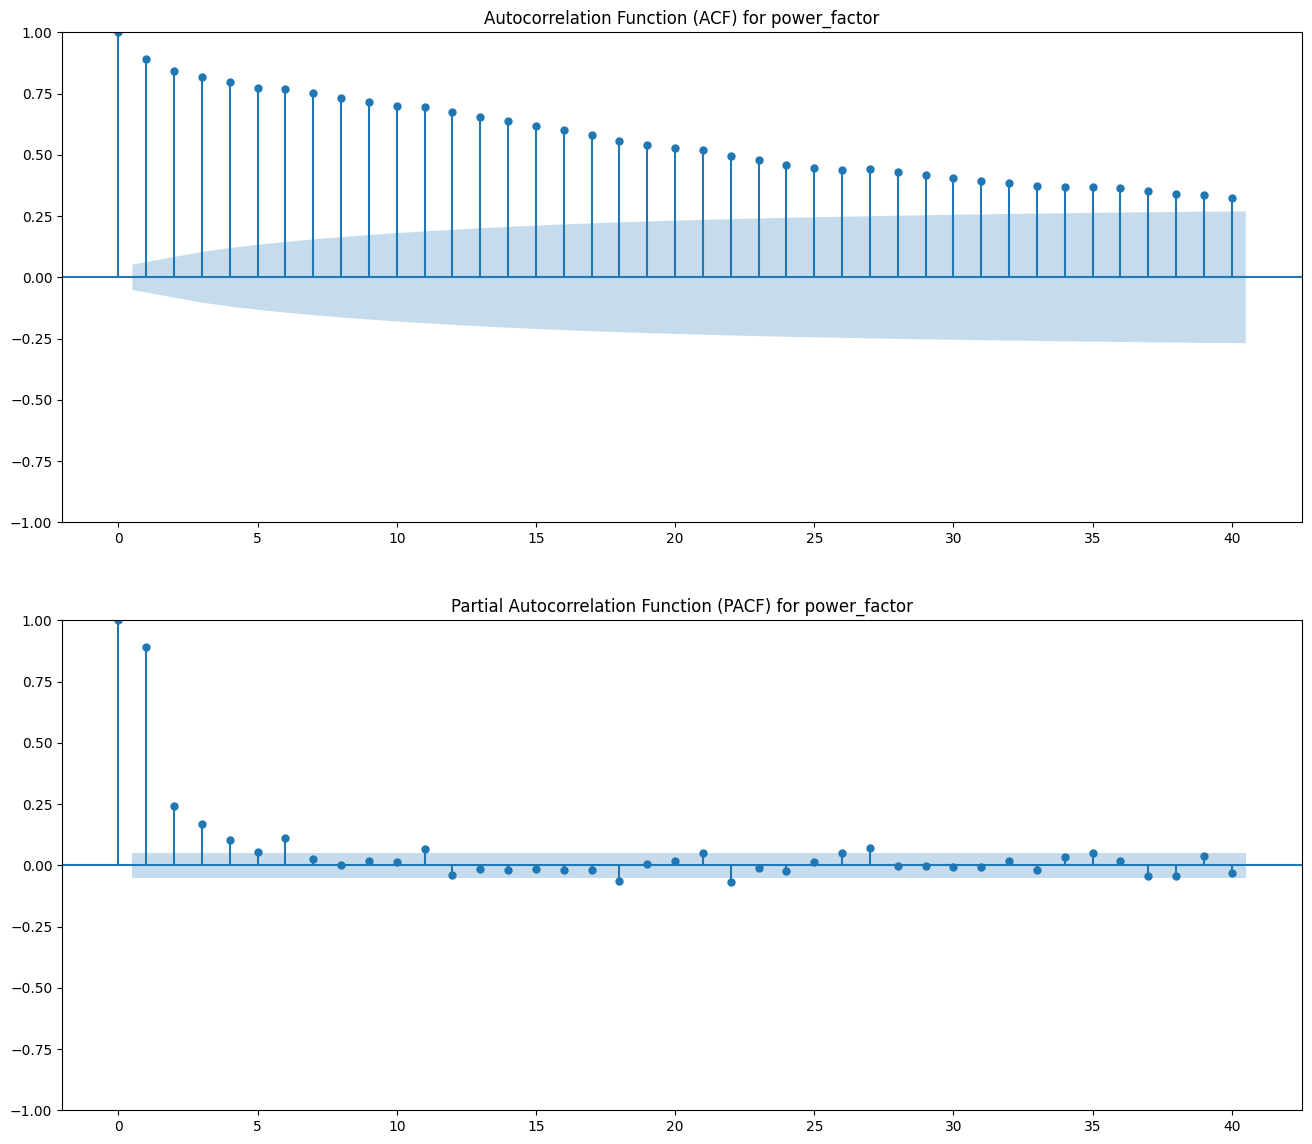

In [204]:
fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# Plot ACF
plot_acf(df1['power_factor'], ax=axes[0], lags=40,fft=True, title='Autocorrelation Function (ACF) for power_factor') # fft=True is for using Fast Fourier Transform for faster computation

# Plot PACF
plot_pacf(df1['power_factor'], ax=axes[1], lags=40,method="ywm", title='Partial Autocorrelation Function (PACF) for power_factor') # method="ywm" is for using Yule-Walker method for faster computation

plt.show()

## 1. The ADF test can be misleading

* The Augmented Dickey-Fuller test (ADF) checks for a unit root.

* If the p-value < 0.05, it suggests stationarity.

* BUT: ADF can “pass” even if the series still shows clear trend/seasonality, because it mainly detects stochastic trends, not deterministic ones (like yearly seasonality).



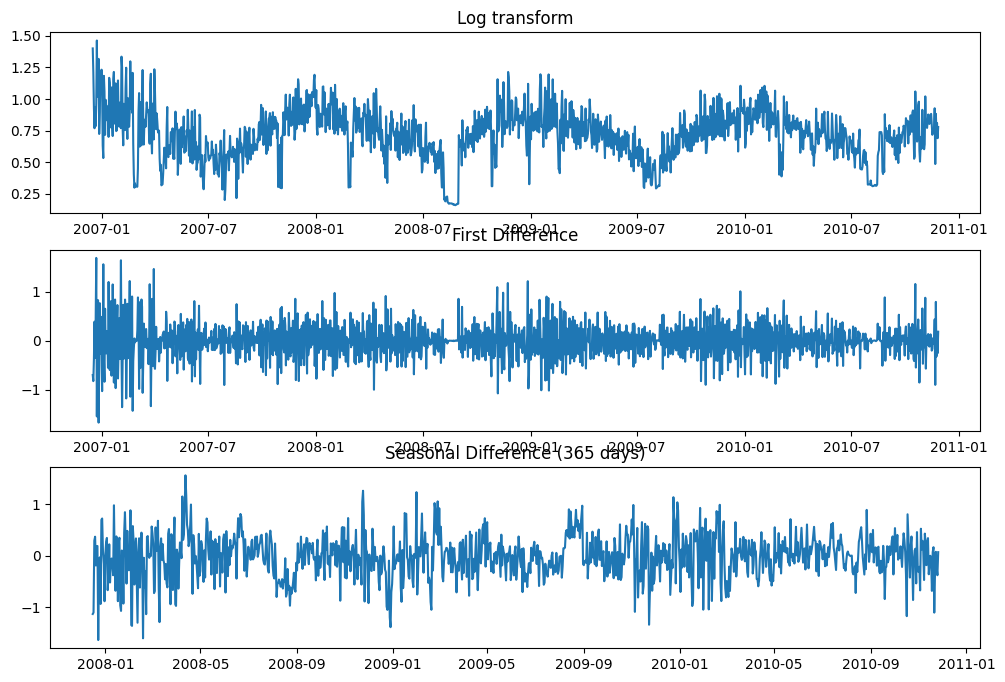

In [205]:


series = df1["global_active_power"]


series_log = np.log1p(series)   # log transform
series_diff = series.diff().dropna()   # first difference
series_seasonal_diff = series.diff(365).dropna()   # yearly differencing

fig, axes = plt.subplots(3,1, figsize=(12,8))
axes[0].plot(series_log); axes[0].set_title("Log transform")
axes[1].plot(series_diff); axes[1].set_title("First Difference")
axes[2].plot(series_seasonal_diff); axes[2].set_title("Seasonal Difference (365 days)")
plt.show()


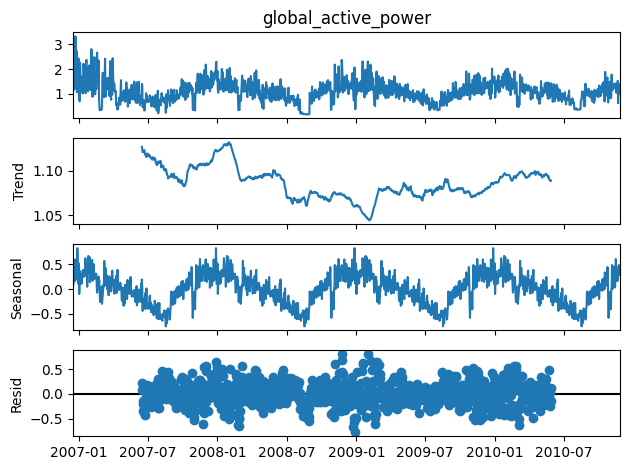

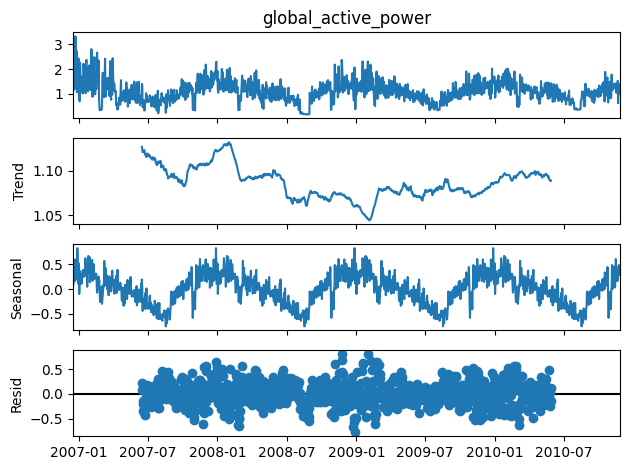

In [206]:
# Decompose (assume daily frequency, adjust period=7 if weekly seasonality)
decomp = seasonal_decompose(series, model='additive', period=365)

decomp.plot()

In [207]:
# df['gap_adj'] = series - decomp.seasonal
# from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(df['gap_adj'], order=(1,1,1))
# result = model.fit()
# print(result.summary())


##  Résultats du modèle SARIMA (R)

Le modèle choisi est :  
**SARIMA(3,1,1)(1,0,0)[7]**

### 🔹 Coefficients estimés :
- AR1 = 0.3183  
- AR2 = -0.0377  
- AR3 = 0.1430  
- MA1 = -0.940  
- SAR1 = 0.2159  

### 🔹 Statistiques du modèle :
- σ² = 0.08771  
- Log Likelihood = -289.4  
- AIC = 590.8  
- AICc = 590.86  
- BIC = 622.44  

### 🔹 Mesures d’erreur (ensemble d’entraînement) :

| Metric | Value   |
|--------|---------|
| ME     | -0.0056 |
| RMSE   | 0.2955  |
| MAE    | 0.2203  |
| MPE    | -8.78   |
| MAPE   | 23.88%  |
| MASE   | 0.7713  |
| ACF1   | -0.0011 |

---

👉 **Interprétation :**  
- Le modèle capte assez bien la dynamique (ME proche de 0).  
- Cependant, le **MAPE = 23.9%** reste relativement élevé → les prévisions à court terme manquent de précision.  
- Une amélioration pourrait passer par des transformations supplémentaires ou l’essai de modèles plus complexes (SARIMAX, Prophet, LSTM).  


In [208]:

df.index = pd.to_datetime(df.index)


last_month = df.index.max() - pd.DateOffset(days=30)

train = df[df.index <= last_month]
test  = df[df.index > last_month]

print("Train:", train.shape, "Test:", test.shape)


Train: (2032059, 8) Test: (43200, 8)


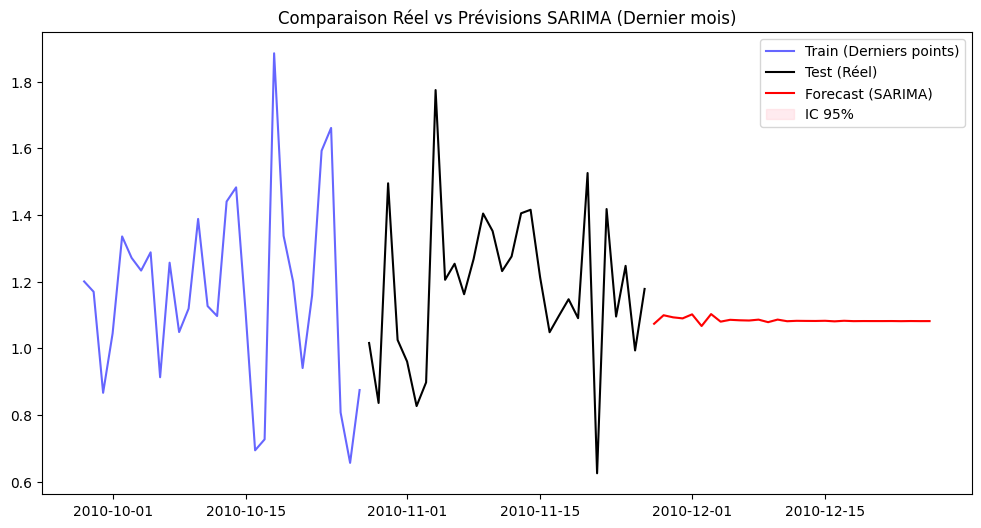

In [209]:

order = (3, 1, 1)
seasonal_order = (1, 0, 0, 7)

params = {
    "ar.L1": 0.3183,
    "ar.L2": -0.0377,
    "ar.L3": 0.1430,
    "ma.L1": -0.940,
    "ar.S.L7": 0.2159
}

# --- Construction du modèle ---
model = SARIMAX(
    df1['global_active_power'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Injecter les paramètres de R
res = model.filter([params.get(k, 0) for k in model.param_names])

# --- On définit une fenêtre (ex: dernier mois réel) ---
last_obs = 30  # nombre de jours à comparer
train = df1.iloc[:-last_obs]     # données d’entraînement
test = df1.iloc[-last_obs:]      # vrai dernier mois

# Forecast sur la période test
forecast = res.get_forecast(steps=last_obs)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,6))

# Derniers 30 points de train
plt.plot(train.index[-30:], train['global_active_power'].iloc[-30:], 
         label="Train (Derniers points)", color="blue", alpha=0.6)

# Série réelle du test (dernier mois)
plt.plot(test.index, test['global_active_power'], label="Test (Réel)", color="black")

# Prévisions du modèle
plt.plot(forecast_mean.index, forecast_mean, label="Forecast (SARIMA)", color="red")

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1],
                 color="pink", alpha=0.3, label="IC 95%")

plt.legend()
plt.title("Comparaison Réel vs Prévisions SARIMA (Dernier mois)")
plt.savefig(filepath_f('SARIMA FORCAST !'))

##  Note on SARIMA Predictions

During the modeling process, I trained a **SARIMA(3,1,1)(1,0,0)[7]** model (with coefficients estimated in R).  
The goal was to validate its ability to forecast electricity consumption, especially for the **last month** of the dataset.  

###  Observation
Although the SARIMA model fitted the training data reasonably well, the **predictions did not align well** with the real test values:
- The forecast line does not capture the fluctuations of the last month.
- The confidence intervals are wide, showing high uncertainty.
- Error metrics such as **MAPE (~23.9%)** remain relatively high, which indicates weak short-term predictive power.

###  Interpretation
This means that:
1. **SARIMA captures seasonality** (weekly pattern in this case), but it struggles with **irregular fluctuations** in electricity consumption.  
2. The data might be influenced by **external factors** (weather, holidays, household behavior) that SARIMA cannot model directly.  
3. Decomposing the series (Trend + Seasonality + Residual) and applying **ARIMA on the residuals** might work better.  

###  Next Steps
- Try **Prophet (Facebook’s library)** or **LSTM/GRU neural networks** to capture nonlinear patterns.  
- Consider **feature engineering** (temperature, weekday/weekend, holidays).  
- Perform a **model comparison**: ARIMA vs SARIMA vs ML/DL models.  

 Conclusion: **SARIMA alone is not sufficient** for accurate forecasting in this dataset. It provides a baseline but should be combined with other approaches for better results.


In [210]:
test.index , train.index[-30:]

(DatetimeIndex(['2010-10-28', '2010-10-29', '2010-10-30', '2010-10-31',
                '2010-11-01', '2010-11-02', '2010-11-03', '2010-11-04',
                '2010-11-05', '2010-11-06', '2010-11-07', '2010-11-08',
                '2010-11-09', '2010-11-10', '2010-11-11', '2010-11-12',
                '2010-11-13', '2010-11-14', '2010-11-15', '2010-11-16',
                '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
                '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
                '2010-11-25', '2010-11-26'],
               dtype='datetime64[ns]', name='dt', freq='D'),
 DatetimeIndex(['2010-09-28', '2010-09-29', '2010-09-30', '2010-10-01',
                '2010-10-02', '2010-10-03', '2010-10-04', '2010-10-05',
                '2010-10-06', '2010-10-07', '2010-10-08', '2010-10-09',
                '2010-10-10', '2010-10-11', '2010-10-12', '2010-10-13',
                '2010-10-14', '2010-10-15', '2010-10-16', '2010-10-17',
                '2010-10-18', 

## XGboost

* Prepa

In [211]:

data = df1.copy()
data = data[['global_active_power']]

# Créer des features de retard (lags)
def create_lag_features(data, n_lags=7):
    df_lags = data.copy()
    for lag in range(1, n_lags+1):
        df_lags[f"lag_{lag}"] = df_lags['global_active_power'].shift(lag)
    return df_lags.dropna()


In [212]:
df_lags = create_lag_features(data, n_lags=7)
df_lags

,global_active_power,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
dt,,,,,,,,
2006-12-23,3.314851,1.625929,1.193616,1.545658,1.157079,1.530435,2.354486,3.053475
2006-12-24,1.770842,3.314851,1.625929,1.193616,1.545658,1.157079,1.530435,2.354486
2006-12-25,1.904944,1.770842,3.314851,1.625929,1.193616,1.545658,1.157079,1.530435
2006-12-26,2.732021,1.904944,1.770842,3.314851,1.625929,1.193616,1.545658,1.157079
2006-12-27,1.061639,2.732021,1.904944,1.770842,3.314851,1.625929,1.193616,1.545658
...,...,...,...,...,...,...,...,...
2010-11-22,1.417733,0.625632,1.525699,1.090556,1.147328,1.098633,1.048436,1.213460
2010-11-23,1.095511,1.417733,0.625632,1.525699,1.090556,1.147328,1.098633,1.048436
2010-11-24,1.247394,1.095511,1.417733,0.625632,1.525699,1.090556,1.147328,1.098633


* splitting

In [213]:
# Train/test split (dernier mois en test)
train = df_lags.iloc[:-30]
test = df_lags.iloc[-30:]

X_train, y_train = train.drop('global_active_power', axis=1), train['global_active_power']
X_test, y_test = test.drop('global_active_power', axis=1), test['global_active_power']



* GridSearch

In [214]:

# Définir la grille de paramètres
param_grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = XGBRegressor(random_state=42)


grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
Best Score (MSE): 0.08910734066943328


In [215]:
# use the best params

In [216]:
model = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=500,
    subsample=0.8,
    random_state=42
)

# Entraînement
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [217]:
y_pred = model.predict(X_test)

* Evaluation 

In [218]:

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0756, MAE: 0.1943


* Visualisation :

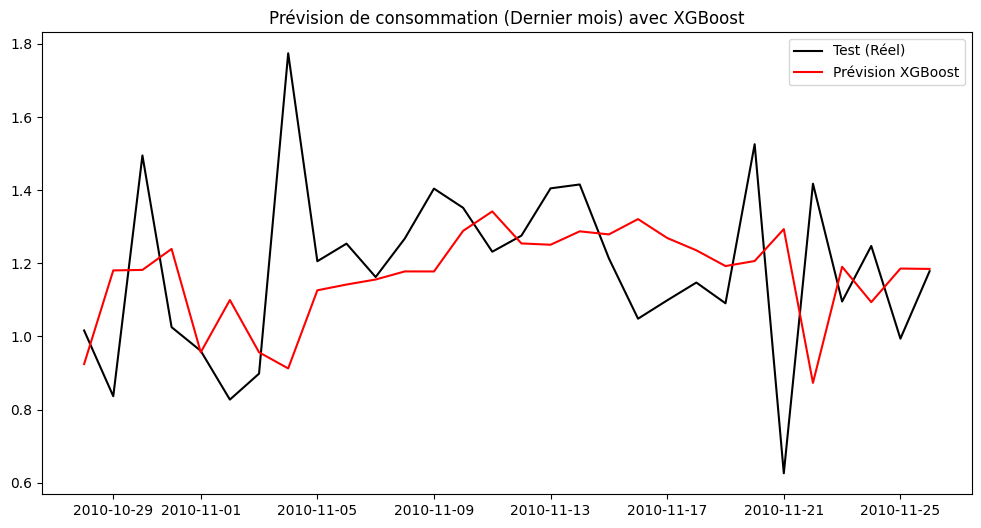

In [219]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Test (Réel)", color="black")
plt.plot(y_test.index, y_pred, label="Prévision XGBoost", color="red")
plt.legend()
plt.title("Prévision de consommation (Dernier mois) avec XGBoost")
plt.savefig(filepath_f('Prévision de consommation (Dernier mois) avec XGBoost !'))


## Prediction Using Energy Features 

In [220]:
data_xb = df1.copy()

train = data_xb[data_xb.index <= last_month]
test  = data_xb[data_xb.index > last_month]

X_train = train.drop(columns=['global_active_power','power_factor'],axis=1)
y_train = train['global_active_power']

X_test = test.drop(columns=['global_active_power','power_factor'],axis=1)
y_test = test['global_active_power']

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1412, 6) Test: (30, 6)


* GridSearch:

In [221]:

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 1}
Best Score (MSE): 0.0018372551505100804


In [222]:
model = XGBRegressor(
    colsample_bytree=1,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=1000,
    subsample=1,
    random_state=42
)


In [223]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MSE: 0.0001
RMSE: 0.0120


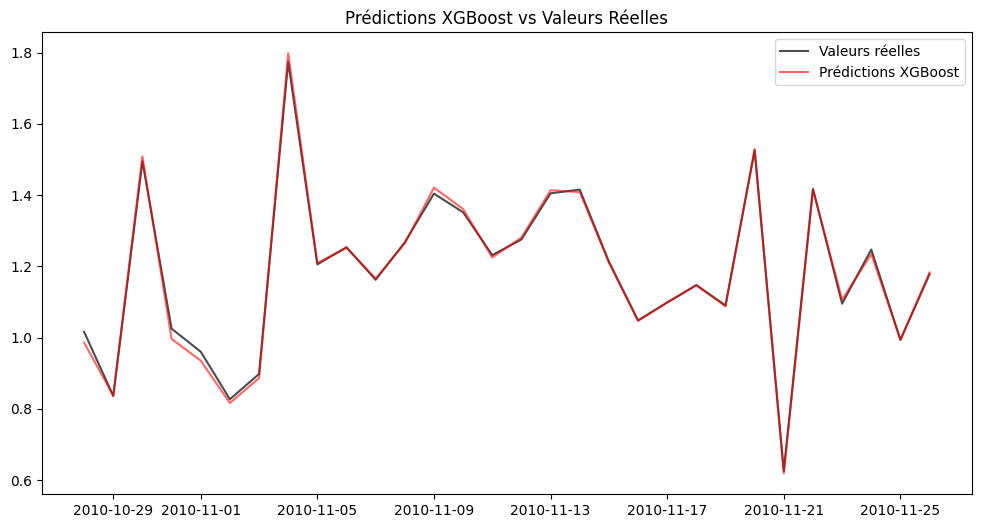

In [ ]:
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Valeurs réelles", color="black" , alpha=0.7)
plt.plot(y_test.index, y_pred, label="Prédictions XGBoost", color="red",alpha=0.6)
plt.legend()
plt.title("Prédictions XGBoost vs Valeurs Réelles")
plt.savefig(filepath_f('Prédictions XGBoost vs Valeurs Réelles'))

## XGboost IS THE BEST MODEL FOR NOW !

In [225]:

importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                 Feature  Importance
2       global_intensity    0.567856
4         sub_metering_2    0.000355
1                voltage    0.000247
5         sub_metering_3    0.000175
0  global_reactive_power    0.000166
3         sub_metering_1    0.000087


In [226]:
# Save
model.save_model("../outputs/xgb_model.json")

# Load later
loaded_model = XGBRegressor()
loaded_model.load_model("../outputs/xgb_model.json")


## Deep Learning : LSTM

* Data Preparing:

In [227]:

from torch.utils.data import DataLoader, TensorDataset


n_lags = 7
data_lags = create_lag_features(df1[['global_active_power']], n_lags)

# --- 2. Normalisation ---
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data_lags)
scaled = pd.DataFrame(scaled, columns=data_lags.columns, index=data_lags.index)

# --- 3. Préparer X et y ---
X = scaled[[f"lag_{i}" for i in range(1, n_lags+1)]].values
y = scaled['global_active_power'].values

# Convertir en tenseurs PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

# --- 4. Dataset et DataLoader ---
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.9 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




* LE modele

In [228]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = x.unsqueeze(1) 
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out
    

X_tensor.shape

torch.Size([1435, 7])

* Entraînement

In [229]:

input_dim = n_lags
hidden_dim = 50
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, num_layers)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        # print('i am in the loop of')
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")


Epoch 10/100, Loss: 0.009269
Epoch 20/100, Loss: 0.005858
Epoch 30/100, Loss: 0.012172
Epoch 40/100, Loss: 0.020001
Epoch 50/100, Loss: 0.006997
Epoch 60/100, Loss: 0.006328
Epoch 70/100, Loss: 0.007262
Epoch 80/100, Loss: 0.005128
Epoch 90/100, Loss: 0.002128
Epoch 100/100, Loss: 0.008045


* Evaluation 

C:\Users\DELL\AppData\Local\Temp\ipykernel_56216\3745318663.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_tensor[-30:], dtype=torch.float32)


MSE sur le dernier mois: 0.075883


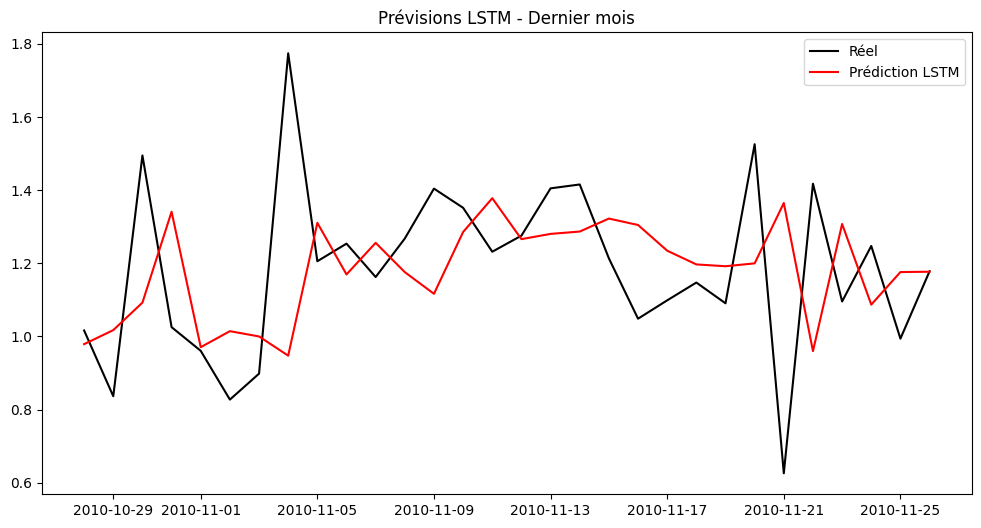

In [230]:

model.eval()
X_test = torch.tensor(X_tensor[-30:], dtype=torch.float32)
y_test = y_tensor[-30:].numpy()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# Inverser la normalisation
y_pred_inv = scaler.inverse_transform(np.concatenate([X_tensor[-30:].numpy(), y_pred], axis=1))[:,-1]
y_test_inv = scaler.inverse_transform(np.concatenate([X_tensor[-30:].numpy(), y_test.reshape(-1,1)], axis=1))[:,-1]


plt.figure(figsize=(12,6))
plt.plot(df1.index[-30:], y_test_inv, label="Réel", color="black")
plt.plot(df1.index[-30:], y_pred_inv, label="Prédiction LSTM", color="red")
plt.title("Prévisions LSTM - Dernier mois")
plt.legend()
plt.savefig(filepath_f('Prévisions LSTM - Dernier mois'))


mse = np.mean((y_test_inv - y_pred_inv)**2)
print(f"MSE sur le dernier mois: {mse:.6f}")


###  Sauvegarder

In [231]:

torch.save(model.state_dict(), "../outputs/lstm_model_state.pth")

# Recharger
model_loaded = LSTMModel(input_dim, hidden_dim, num_layers)
model_loaded.load_state_dict(torch.load("../outputs/lstm_model_state.pth"))
model_loaded.eval()


LSTMModel(
  (lstm): LSTM(7, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## LSTM FAIT UN BON TRAVAIL AUSSI 